In [7]:
%pip install torchvision
%pip install torch --index-url https://download.pytorch.org/whl/cu118
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


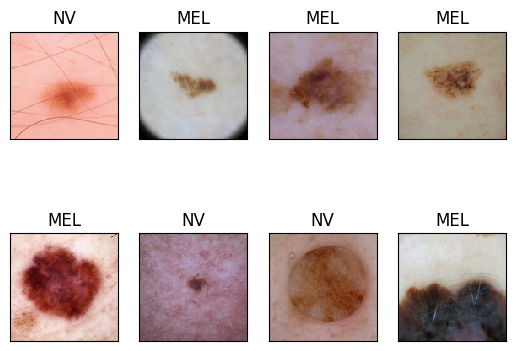

In [13]:


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

train_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/train', transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(train_loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])


In [18]:
import torch
import torchvision
val_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/val', transform=torchvision.transforms.ToTensor())
val_loader = DataLoader(val_folder, batch_size=8, shuffle=True)

Got code from canvas to train our classfier. 

In [193]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_classifier(model, train_data, val_data, hyperparams):

    # Deals with model updates. Adam is more effective than SGD.
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])    
    
    # Binary Cross-entropy loss because we have 2 classes.
    # Note that the softmax is "baked into" this loss, so we should not
    # use a softmax at the end.
    loss_func = torch.nn.BCELoss()
      
    # Some statistics.
    acc_history = []

    for epoch in range(hyperparams['n_epochs']):

        # Set the model in training mode, enabling dropout if we use that.
        model.train()
        
        loss_sum = 0

        # For each batch
        for Xbatch, Ybatch in tqdm(train_data):
            # Apply the model. We don't know at this point what the model is.
            # The output should be of the shape (batch_size, 10).
            outputs = model(Xbatch)
            #print("labels ", Ybatch)
            #print("outputsshape ",outputs)
            #outputs=outputs[:]
            # Apply the cross-entropy loss.
            loss = loss_func(outputs.squeeze(), Ybatch.float())

            # Update the model.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()

        # Set the model in evaluation mode. Disables dropout if present.
        model.eval()
        with torch.no_grad():
            # Compute the accuracy on the validation data.
            val_acc = predict_and_evaluate(model, val_data)
                
        mean_loss = loss_sum / len(train_data)

        acc_history.append(val_acc)
        
        print(f'Epoch {epoch+1}: loss = {mean_loss:.4f}, val acc = {val_acc:.4f}')
    
    return acc_history
        
    
# A utility function to compute accuracies during training.
def predict_and_evaluate(model, data):
    
    all_gold = []
    all_pred = []
    
    for Xbatch, Ybatch in data:
        outputs = model(Xbatch)
        predictions = torch.round(outputs)
        
        all_gold.extend(Ybatch.numpy())
        all_pred.extend(predictions.numpy())

    return accuracy_score(all_gold, all_pred) 

In [187]:
import torch.nn as nn
import torch.nn.functional as F

class StepByStepCNN(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel rgb
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks)
        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.output = nn.Linear(512, 1)

    def flatten_size(self, ks):
        if ks == 3:
            return 64*30*30
        elif ks == 5:
            return 64*29*29
        else: 
            return 0 
           
    def forward(self, X):
        c1 = self.conv1(X)
        fm1 = F.max_pool2d(F.relu(c1), 2)
        c2 = self.conv2(fm1)
        fm2 = F.max_pool2d(F.relu(c2), 2)
        # This was used to calculate flattened size
        # print(fm2.shape)
        fl = torch.flatten(fm2, start_dim=1)
        h1 = F.relu(self.fc(fl))
        #print(h1)
        out = torch.sigmoid(self.output(h1))
        #print(out)
        return out

In [194]:
torch.random.manual_seed(2)
cnn = StepByStepCNN(5)
history = train_classifier(cnn, train_loader, val_loader,{'lr': 1e-3, 'n_epochs': 1})


100%|█████████████████████████████████████████████████████████████████████████████████| 804/804 [02:18<00:00,  5.79it/s]


Epoch 1: loss = 0.5302, val acc = 0.7300
